In [115]:
# Librerías que se usarán

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from astropy import units as u
import emcee
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.optimize import minimize
import pylab as py
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.linear_model import HuberRegressor
from astropy import units as u
from astropy import coordinates as coords
from astroquery.skyview import SkyView
from photutils import CircularAperture
from astropy.visualization import simple_norm
import corner

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams.update({"font.size": 13, "font.family": "serif"})


# Extracción datos

In [3]:
# Importamos los datos del .csv adjunto
df_P1 = pd.read_csv('sn-data.csv')
df_P1 = df_P1.sort_values(by=['redshift'])

# Extraemos los datos en NumPy arrays
redshift = np.array(df_P1.iloc[:, 0])
dist_mod = np.array(df_P1.iloc[:, 1])
err_dist_mod = np.array(df_P1.iloc[:, 2])

df_P1.head()

,redshift,dist_mod,err_dist_mod
37,0.0150,34.111411,0.213389
48,0.0150,34.379773,0.217349
49,0.0153,34.707186,0.213243
39,0.0187,35.048300,0.197197
0,0.0192,34.491562,0.197092


<ipython-input-3-c2a05163e033>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


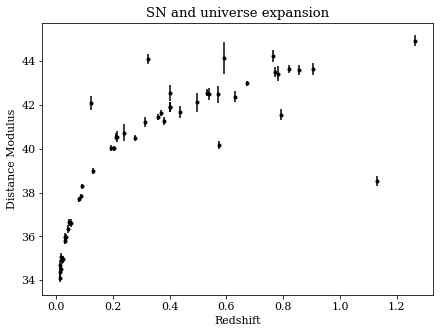

In [3]:
# Veamos cómo son los datos
fig1, ax1 = plt.subplots(figsize=(7, 5))
ax1.errorbar(redshift, dist_mod, yerr=err_dist_mod, fmt='.k')
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Distance Modulus')
ax1.set_title('SN and universe expansion')
fig1.show()

Notamos que al parecer hay outlayers para los valores más grandes de redshift (que se encuentran más lejos) y que la relación al parecer tiene una tendencia siempre creciente, aunque disminuyendo la tasa de crecimiento para redshift más grandes.\\

A simple vista podría fitearse con una relación de la forma $f(x)=\sqrt x$ o una porción de un polinomio de grado $n$

# Pregunta 1

## P1. a)

In [69]:
# Separamos los datos en train (para entrenar nuestro algoritmo) y test para testear el modelo
X_train, X_test, y_train, y_test = train_test_split(redshift, dist_mod, test_size=0.33, random_state=10)

In [5]:
# Listas para guardar los RMS
rms_test_list = []
rms_train_list = []
# Array para guardar los parámetros finales
estParms_2D = np.zeros((10, 12))

for i in range(0, 10):
  """
  Intentamos modelos polinomiales desde grado 0 a grado 9.
  """

  def polynomial(params):
      yPred = np.zeros((len(X_train)))
      for j in range(0, i+1):
        # Con este bucle for creamos el polinomio de grado i
        yPred += params[j]*X_train**int(j)

      # Calculamos el logaritmo negativo del likelihood
      LL = -np.sum(stats.norm.logpdf(y_train, loc=yPred))

      return(LL)


  # Como parámetros iniciales usamos todo igual a 1
  initParams = np.ones((i+1))

  # Minimizamos el logaritmo negativo del likelihood variando los parámetros
  results = minimize(polynomial, initParams, method='Nelder-Mead')

  estParms = results.x  # parámetros finales

  estParms_2D[i, :i+1] = estParms[:i+1]  # guardamos los parámetros finales

  # Arreglos para guardar las predicciones del modelo
  yOut_test = np.zeros((len(X_test)))
  yOut_train = np.zeros((len(X_train)))

  for j in range(0, i+1):
    # Obtenemos los resultados predichos para X_test y X_train
    yOut_test += estParms[j]*X_test**(int(j))
    yOut_train += estParms[j]*X_train**(int(j))

  # Guardamos los RMS y los agregamos a las listas vacías
  rms_test = np.sqrt(mean_squared_error(y_test, yOut_test))
  rms_train = np.sqrt(mean_squared_error(y_train, yOut_train))

  rms_test_list.append(rms_test)
  rms_train_list.append(rms_train)

  #print ('Para el polinomio de grado', i, 'los parámetros son: ', estParms)


<ipython-input-6-6cf739452769>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


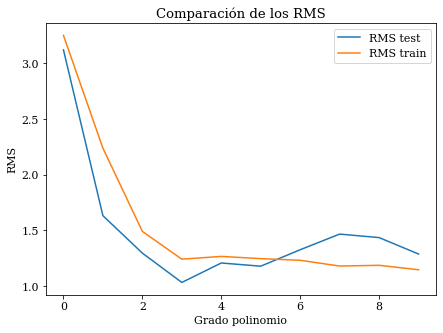

In [6]:
fig2, ax2 = plt.subplots(figsize=(7, 5))
ax2.plot(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8,9]), rms_test_list, label='RMS test')
ax2.plot(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8,9]), rms_train_list, label='RMS train')
ax2.set_title('Comparación de los RMS')
ax2.set_xlabel('Grado polinomio')
ax2.set_ylabel('RMS')
ax2.legend()
fig2.show()

Como podemos ver en el gráfico de arriba, el RMS del set train tiende siempre a la disminución, mientras que el RMS del set test comienza disminuyendo, alcanzando su mínimo en el grado $n=3$ donde comienza a aumentar. Como conseguimos el menor RMS usando un polinomio de grado 3, nos quedamos con este grado para hacer el fit de los datos.

Veamos cómo se ve este modelo comparado con los datos

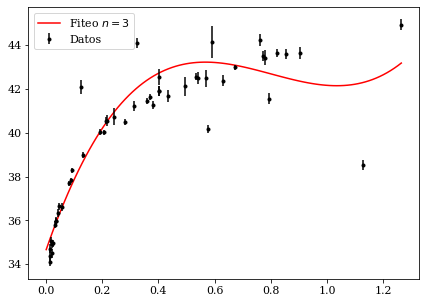

In [7]:
# Ploteamos en todo el rango de redshift
x_plot = np.linspace(0, np.max(redshift), 100)

# Calculamos el arreglo con los datos predichos con los parámetros finales con n=3
testing = estParms_2D[3, 3]*x_plot**3 + estParms_2D[3, 2]*x_plot**2 + estParms_2D[3, 1]*x_plot + estParms_2D[3, 0]

# Plot
fig3, ax3 = plt.subplots(figsize=(7, 5))
ax3.plot(x_plot, testing, label='Fiteo $n=3$', color='red')
ax3.errorbar(redshift, dist_mod, yerr=err_dist_mod, fmt='.k', label='Datos')
ax3.legend()

## P1. b)

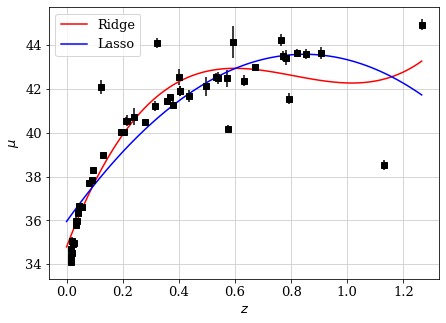

In [102]:
lambda_array = np.linspace(0.001, 2, 5000)

x_to_plot2 = x_to_plot.copy().reshape(-1, 1)
X_polynomial = PolynomialFeatures(3).fit_transform(x_to_plot2)

# Regresión Ridge
X_polynomial_ridge = PolynomialFeatures(3).fit_transform(redshift.reshape(-1, 1))

clf_ridge = RidgeCV(alphas = lambda_array).fit(X_polynomial_ridge, dist_mod)
y_pred_ridge = clf_ridge.predict(X_polynomial)

# Regresión Lasso
X_polynomial_lasso = PolynomialFeatures(3).fit_transform(redshift.reshape(-1, 1))

clf_lasso = LassoCV(alphas = lambda_array).fit(X_polynomial_lasso, dist_mod)
y_pred_lasso = clf_lasso.predict(X_polynomial)

fig7, ax7 = plt.subplots(figsize=(7, 5))
ax7.errorbar(redshift, dist_mod, yerr=err_dist_mod, ls='None', marker='s', color='black')
ax7.plot(x_to_plot2, y_pred_ridge, label = 'Ridge', color='red')
ax7.plot(x_to_plot2, y_pred_lasso, label = 'Lasso', color='blue')
ax7.set_xlabel('$z$')
ax7.set_ylabel('$\mu$')
ax7.legend()

Para comparar las dos regresiones analizamos los RMS

In [108]:
# Calculamos los RMS
y_predRidge = clf_ridge.predict(X_polynomial_ridge)
y_predLasso = clf_lasso.predict(X_polynomial_lasso)

rms_ridge = mean_squared_error(dist_mod, y_predRidge)
rms_lasso = mean_squared_error(dist_mod, y_predLasso)

print('La regresión Lasso tiene un RMS de:', rms_lasso, 'mientras que la Ridge:', rms_ridge)

La regresión Lasso tiene un RMS de: 2.0218369247268466 mientras que la Ridge: 1.3389063510619226


## P1. c)

Text(0.5, 1.0, 'Comparación de los RMS')

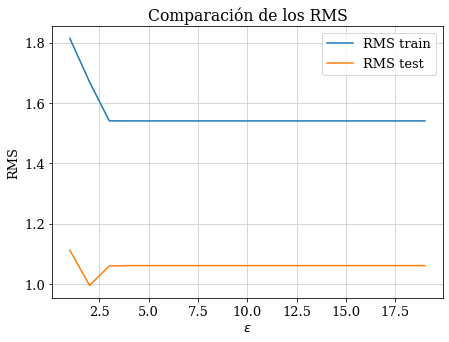

In [82]:
# Definimos una lista con posibles valores del hiper parámetro
epsilon_array = np.arange(1, 20)

# Listas vacías donde guardaremos los RMS de train y test
rms_train_huber = []
rms_test_huber = []

# Hacemos la regresión Hubber loss para cada valor de epsilon
for epsilon in epsilon_array:
    # Creamos los inputs de HuberRegressor.fit a partir de los sets de train y test
    X_poly_huber_test = PolynomialFeatures(3).fit_transform(X_test.reshape(-1, 1))
    X_poly_huber_train = PolynomialFeatures(3).fit_transform(X_train.reshape(-1, 1))

    # Realizamos la regresión con el set train
    clf_hub = HuberRegressor(epsilon).fit(X_poly_huber_train, y_train)

    # Predicciones
    y_pred_huber_train = clf_hub.predict(X_poly_huber_train)
    y_pred_huber_test = clf_hub.predict(X_poly_huber_test)

    # Cálculo de los RMS
    rms_train = mean_squared_error(y_train, y_pred_huber_train)
    rms_test = mean_squared_error(y_test, y_pred_huber_test)

    # Se van agregando los valores
    rms_train_huber.append(rms_train)
    rms_test_huber.append(rms_test)

# Plot
fig9, ax9 = plt.subplots(figsize=(7, 5))
ax9.plot(epsilon_array, rms_train_huber, label = 'RMS train')
ax9.plot(epsilon_array, rms_test_huber, label = 'RMS test')
ax9.legend()
ax9.set_xlabel('$\epsilon$')
ax9.set_ylabel('RMS')
ax9.set_title('Comparación de los RMS')


A simple vista parece que los RMS se vuelven constantes, pero tienen pequeñas diferencias, porque para elegir el hiper parámetro que minimza el RMS (nuestro criterio para elegir el hiper parámetro), utilizamos la función $\texttt{np.min}$.

In [104]:
# Buscamos el índice donde el RMS de test sea mínimo
index = np.where(rms_test_huber == np.min(rms_test_huber))[0]

# Seleccionamo el epsilon en la posición index
epsilon_final = epsilon_array[index][0]

Visualizemos las regresiones hechas por Ridge, Lasso y Huber loss

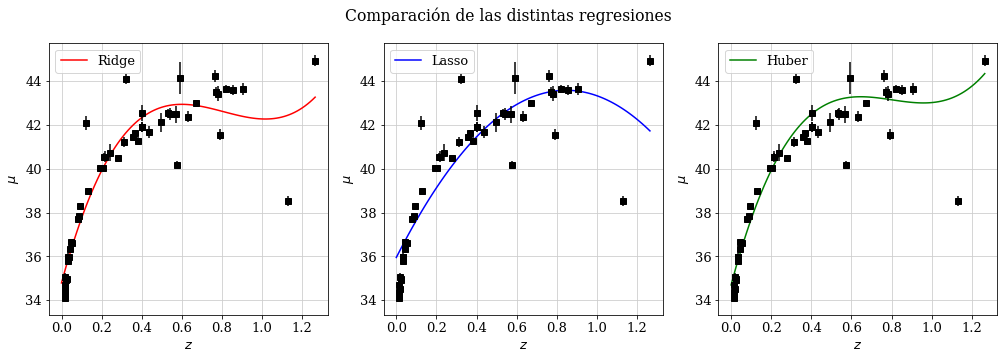

In [105]:
X_poly_huber_train = PolynomialFeatures(3).fit_transform(X_train.reshape(-1, 1))
clf_hub_final = HuberRegressor(epsilon_final).fit(X_poly_huber_train, y_train)

X_poly_huber_to_plot = PolynomialFeatures(3).fit_transform(x_to_plot.reshape(-1, 1))

y_pred_hub = clf_hub_final.predict(X_poly_huber_to_plot)

fig10, (ax101, ax102, ax103) = plt.subplots(1, 3, figsize=(17, 5))
fig10.suptitle('Comparación de las distintas regresiones')
ax101.plot(x_to_plot2, y_pred_ridge, label = 'Ridge', color='red')
ax101.errorbar(redshift, dist_mod, yerr=err_dist_mod, ls='None', marker='s', color='black')
ax101.set_xlabel('$z$')
ax101.set_ylabel('$\mu$')
ax101.legend()

ax102.plot(x_to_plot2, y_pred_lasso, label = 'Lasso', color='blue')
ax102.errorbar(redshift, dist_mod, yerr=err_dist_mod, ls='None', marker='s', color='black')
ax102.set_xlabel('$z$')
ax102.set_ylabel('$\mu$')
ax102.legend()

ax103.plot(x_to_plot2, y_pred_hub, label = 'Huber', color='green')
ax103.errorbar(redshift, dist_mod, yerr=err_dist_mod, ls='None', marker='s', color='black')
ax103.set_xlabel('$z$')
ax103.set_ylabel('$\mu$')
ax103.legend()


In [109]:
# Comparación de RMS de las 3 regresiones
print('Donde los RMS son:', rms_ridge, 'para Ridge,', rms_lasso, 'para Lasso y', np.min(rms_test_huber), 'para Huber.')

Donde los RMS son: 1.3389063510619226 para Ridge, 2.0218369247268466 para Lasso y 0.9955980396833863 para Huber.


Con lo que vemos que la regresión Huber loss nos entrega el menor RMS de las 3.

# Pregunta 2

Para esta pregunta nos basaremos en el código usado por el profesor Valentino González. El github está [aquí.](https://github.com/thevalentino/AS450-astroinformatica)

In [43]:
def mu_Peebles(z, H_0, Omega_m, Omega_lambda):
    """
    Esta función toma como input el redshift del objeto y las constantes:
    constante de Hubble, densidad de materia y la constante cosmológica.
    Entrega el valor de la distancia en modulo calculada con el modelo
    de Peebles que se menciona en la tarea.
    """
    def integral_fn(x):
        """
        Función que calcula la integral del modelo
        """
        return 1/((Omega_m*(1 + x)**3 + Omega_lambda)**0.5)

    integral = quad(integral_fn, 0, z)[0]

    # Se especifican las unidades de las constantes
    c_united = 300000*u.km/u.second  # km/s
    H_0_united = H_0/(10**6)*u.kilometer/u.second/u.parsec
    rate = ((c_united/H_0_united).to(u.parsec)).value

    # Se returna la aproximación de la distancia al objeto
    return -5*np.log10(10) + 5*np.log10((1 + z)*rate*integral)

# Vectorizamos la función para poder aplicarla a arrays
vmu_Hubble = np.vectorize(mu_Peebles)


def ln_prior(theta):
    """
    Función que entrega 0 si los parámetros están dentro del rango esperado, y -infinito si alguno está fuera
    """
    H_0, Omega_m, Omega_lambda, Pb, Yb, logVb = theta
    if (0 < H_0 < 90) and (0 < Omega_m < 1) and (0 < Omega_lambda < 1) and (0 < Pb < 1) and (0 < Yb < 2000) and (-2 < logVb < 10):
        return 0
    return -np.inf


def ln_likelihood(theta, x, y, yerr):
    """
    Función que calcula el likelihood
    """
    H_0, Omega_m, Omega_lambda, Pb, Yb, logVb = theta
    Vb = 10**logVb
    model = vmu_Hubble(x, H_0, Omega_m, Omega_lambda)
    p_fg = (1-Pb) / np.sqrt(2 * np.pi * yerr**2) * np.exp(-(y-model)**2/(2 * yerr**2))
    p_bg = Pb / np.sqrt(2 * np.pi * (Vb + yerr**2)) * np.exp(-(y - Yb)**2/(2 * (Vb + yerr**2)))
    output = np.sum(np.log(p_fg + p_bg))
    return output


def ln_posterior(theta, x, y, yerr):
    """
    AGREGAR DESCRIPCIÓN
    """
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    return ln_p + ln_likelihood(theta, x, y, yerr)

Para tener en cuenta los outliers (sobretodo los datos de los redshifts más grandes), consideramos un rango "grande" en el que pueden varias las constantes $H_0$, $\Omega_m$ y $\Omega_\Lambda$. Posteriormente esto se ve cuando graficamos las distintas regresiones.

In [44]:
np.random.seed(6346)  # para que el cálculo sea replicable

# Estos son los valores entregados de: [H_0, Omega_m, Omega_lambda, Pb, Yb, logVb]
theta_0 = np.array([71, 0.27, 0.73, 0.3, 400, 1.])
ndim, nwalkers = 6, 32

# Variamos theta_0 con una distribución al azar para cada nwalkers
pos_0 = [theta_0 + 0.1*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, 
                                args=(redshift, dist_mod, err_dist_mod), threads=8)

In [45]:
%timeit -n1 -r1 sampler.run_mcmc(pos_0, 1000);

2min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


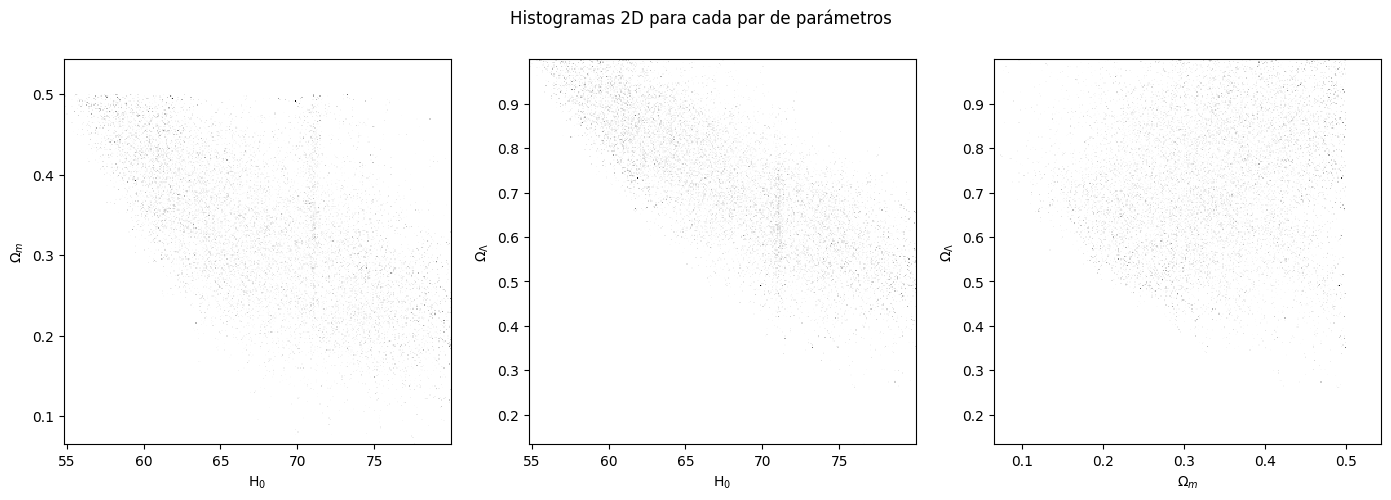

In [28]:

with plt.style.context('default'):
    fig1i, (ax11, ax12, ax13) = plt.subplots(1, 3, figsize=(17, 5))
    fig1i.suptitle('Histogramas 2D para cada par de parámetros')
    hola = ax11.hist2d(sampler.flatchain[:,0], sampler.flatchain[:,1], bins=300, 
               cmap='gray_r')
    ax11.set_xlabel('H$_0$')
    ax11.set_ylabel('$\Omega_m$')

    ax12.hist2d(sampler.flatchain[:,0], sampler.flatchain[:,2], bins=300, 
               cmap='gray_r')
    ax12.set_xlabel('H$_0$')
    ax12.set_ylabel('$\Omega_\Lambda$')

    ax13.hist2d(sampler.flatchain[:,1], sampler.flatchain[:,2], bins=300, 
               cmap='gray_r')
    ax13.set_xlabel('$\Omega_m$')
    ax13.set_ylabel('$\Omega_\Lambda$')

La regresión bayesiana nos entrega distintos sets de los 3 parámetros utilizados, que podemos graficar para analizar su comportamiento, por ejemplo, cuál es la curva donde más regresiones convergen.

Text(0.5, 1.0, 'Diferentes regresiones')

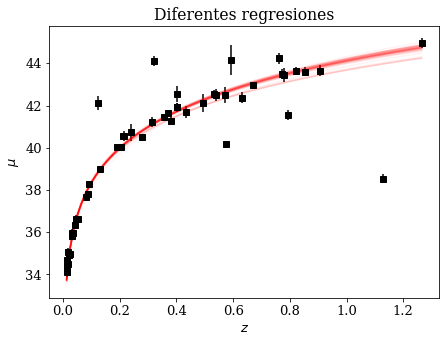

In [46]:
# Ignoramos las advertencias
import warnings
warnings.filterwarnings('ignore')

x_to_plot = np.linspace(0, np.max(redshift), 100)

fig6, ax6 = plt.subplots(figsize=(7, 5))
# Datos
ax6.errorbar(redshift, dist_mod, yerr=err_dist_mod, ls='None', marker='s', color='black')

# Gráfico de las distintas regresiones
for i in np.random.randint(0, high=len(sampler.flatchain), size=50):
    H_0, Omega_m, Omega_lambda = sampler.flatchain[i, [0, 1, 2]]
    ax6.plot(x_to_plot, vmu_Hubble(x_to_plot, H_0, Omega_m, Omega_lambda), color='red', alpha=0.05)

ax6.set_xlabel("$z$")
ax6.set_ylabel("$\mu$")
ax6.set_title('Diferentes regresiones')

Como se mencionó más arriba, habiendo considerando rangos grandes para los parámetros, hay curvas que se desvían de la tendencia central (donde se acumulan) al tender a valores más pequeños de $\mu$ para $z$ más grandes.

Para visualizar de mejor manera las relaciones entre cada par de parámetros y las frecuencias de cada uno para los diferentes valores, ocupamos el paquete $\texttt{corner}$, con lo que conseguimos las joint probability distribution de los parámetros.

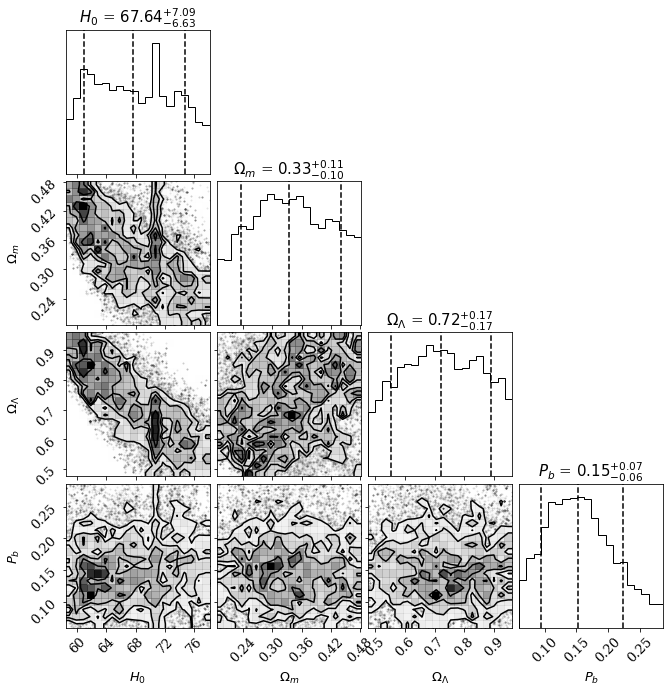

In [42]:
fig7 = corner.corner(sampler.flatchain[:,[0, 1, 2, 3]], 
                    labels=["$H_0$", "$\Omega_m$", "$\Omega_\Lambda$", "$P_b$"], 
                    range=(0.9, 0.9, 0.9, 0.9),
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 15})

# Pregunta 3

Como se sugiere en el enunciado, usamos las libreriías $\texttt{astropy}$ y $\texttt{astroquery}$ para descargar los datos.

In [110]:
# Nombre de la banda r del survey SDSSdr7
survey = 'SDSSdr7r'

# Coordenadas
RA = coords.Longitude(angle="13:39:55.92", unit=u.hourangle)
DEC = coords.Latitude(angle="+00:50:10.02", unit=u.deg)
coordinates = coords.SkyCoord(ra=RA, dec=DEC)

# Dimensiones solicitadas y resolución
width = 30  # [arcmin]
height = 30  # [arcmin]
resol = 0.3  # [arcsec]

# Pasamos las dimensiones a píxeles con la fórmula l[arcmin]/resolution[arcsec]*60
width_pix = int(width/resol*60)
height_pix = int(height/resol*60)

In [111]:
# Obetenemos la data de SkyView
image = SkyView.get_images(
    position=coordinates,
    survey=survey,
    pixels=(width_pix, height_pix),
    width=width*u.arcmin,
    height=height*u.arcmin
)

# Seleccionamos
data = image[0][0].data

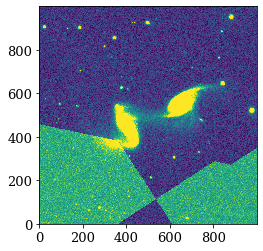

In [129]:
# Graficamos una pequeña región de la data total
ancho = 500
norm = simple_norm(data, "linear", percent=99)
plt.imshow(data[3000-ancho:3000+ancho, 3000-ancho:3000+ancho], norm=norm, interpolation="nearest", origin="lower")
plt.grid(False)